# Red Wine Quality Prediction
By: Ankur Napa

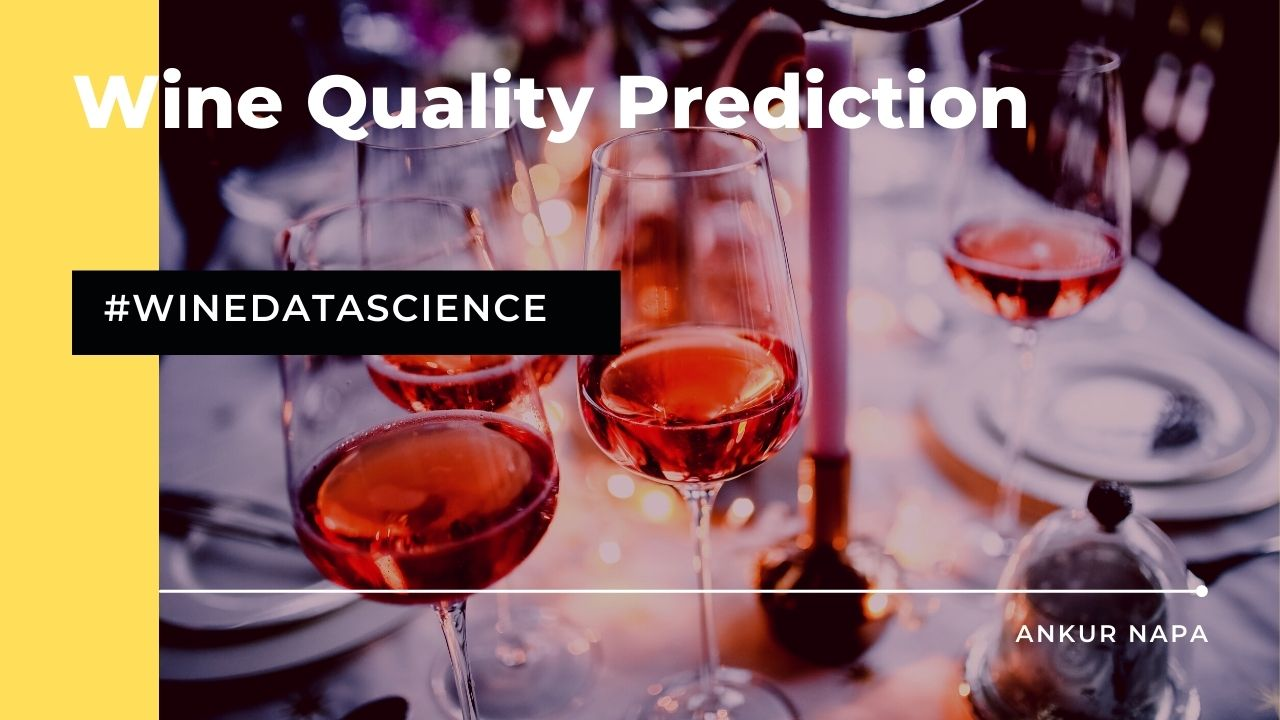
A simple classification problem to identify whether the red wine is 'good' or 'bad' based on several features.

### **Importing dependencies**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os # operating system interaction

from collections import Counter # counting total feature outliers

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder # encoding categoricals
from sklearn.model_selection import train_test_split # train-test split
from sklearn.preprocessing import StandardScaler # standardising

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold, cross_val_score # cross validation

from sklearn.model_selection import GridSearchCV # hyperparameter tuning

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # model evaluation

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### **Loading the dataset**

We will first load the CSV dataset into a Pandas DataFrame. The dataset has 1599 examples with 11 features and one ground truth (class).

In [ ]:
CSV_PATH = "../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv"

df = pd.read_csv(CSV_PATH)

df.shape 

### **Data Exploration**
Now that the dataset is successfully loaded, we will identify each feature, its datatype and check whether the dataset has any missing values.

This step will help us during data preprocessing and even when choosing our classification models.

In [ ]:
df.head()

In [ ]:
df.info()

This is great. All our predictors are entirely numeric which which means that we do not have to handle any categorical features. We also notice that the ground truth is an integer. We will look at this field in more detail now.

In [ ]:
df['quality'].unique()

Turns out, our ground truth has only 6 unique values. Rather than identifying the exact class of the wine based on the predictors, we will transform this feature by allowing it to only take two values corresponding to 'good' or 'bad'. This will allow us to train a binary classifier.

In [ ]:
df['quality'].value_counts()

We must note that there is a class imbalance in the dataset. Each quality class is not represented equally.

In [ ]:
df.isnull().sum()

The dataset has no NULL values. This means that we do not have to impute any values.

### **Tackling outliers**
Some Machine Learning algorithms may work poorly when outliers are also passed to the algorithm. Mainly, models which make use of Euclidean distance for prediction are sensitive to outliers. 

We will simple remove these outliers using Tukey's fences by defining our range as follows:

${\displaystyle {\big [}Q_{1}-1.5(Q_{3}-Q_{1}),Q_{3}+1.5(Q_{3}-Q_{1}){\big ]}}$

where $Q_{1}$ is the 25th percentile and $Q_{3}$ is the 75th percentile

If the value lies outside these bounds, then it is considered to be an outlier.

We can repeat this process for each numerical attribute and if the wine sample has 3 or more attribute outliers, we delete the training example entirely.

In [ ]:
features = df.columns.values.tolist()
features.remove("quality")

outlier_index = list()

for feature in features:
    
    q1 = np.percentile(df[feature], 25)
    q3 = np.percentile(df[feature], 75)
    
    iqr = q3 - q1
    
    step = iqr * 1.5
    
    lower_bound = q1 - step
    upper_bound = q3 + step
    
    # List of indices where the attribute value lies outside the bounds
    feature_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    
    outlier_index.extend(feature_outliers)

outlier_index = Counter(outlier_index) # returns a Counter object (similar to a dictionary)

If a certain training example has 3 or more feature outliers, then we will delete the training example.

In [ ]:
outlier_list = [index for index, count in outlier_index.items() if count > 3]

print(f"Found {len(outlier_list)} outliers in the entire dataset.")

In [ ]:
df.loc[outlier_list]

We can now delete these outliers from our DataFrame. Remaining examples : $1599 - 15 = 1584$

In [ ]:
df = df.drop(outlier_list, axis=0).reset_index(drop=True)
df.shape

### **Data Visualisation**
Now that we have successfully handled outliers, we can plot graphs for each of the features to understand its correlation with our ground truth (quality).

##### **Pearson's Correlation**

In [ ]:
ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df.corr(),annot=True, fmt=".2f", cmap="coolwarm")

From the Pearson's correlation plot we can make out that quality seems to be highly correlated to the alcohol content, sulphates, citric acids, and volatile acidity.

We will explore all the predictors in detail now.

##### **Fixed Acidity**

In [ ]:
sns.lineplot(x="quality", y="fixed acidity", data=df)
plt.title("Fixed Acidity against Quality")
plt.grid()

There is no clear trend between fixed acidity and quality.

##### **Volatile Acidity**

In [ ]:
sns.lineplot(x="quality", y="volatile acidity", data=df)
plt.title("Volatile Acidity against Quality")
plt.grid()

We can clearly observe that as the volatile acidity decreases, the quality score increases.

##### **Citric Acid**

In [ ]:
sns.lineplot(x="quality", y="citric acid", data=df)
plt.title("Citric Acid against Quality")
plt.grid()

It can be seen from the plot that as the citric acid increases, the quality score also increases.

##### **Residual Sugar**

In [ ]:
sns.lineplot(x="quality", y="residual sugar", data=df)
plt.title("Residual Sugar against Quality")
plt.grid()

There is no distinct correlation between the residual sugar and the quality score.

##### **Chlorides**

In [ ]:
sns.lineplot(x="quality", y="chlorides", data=df)
plt.title("Chlorides against Quality")
plt.grid()

As the chloride concentration decreases, the quality score increases.

##### **Free Sulphur Dioxide**

In [ ]:
sns.lineplot(x="quality", y="free sulfur dioxide", data=df)
plt.title("Free SO2 against Quality")
plt.grid()

No clear correlation between free $SO_2$ and quality score.

##### **Total Sulphur Dioxide**

In [ ]:
sns.lineplot(x="quality", y="total sulfur dioxide", data=df)
plt.title("Total SO2 against Quality")
plt.grid()

As the sulphates increase, the quality score increases till 5 then it starts decreasing. Again, there doesn't seem to be a strong positive or negative correlation.

##### **Density**

In [ ]:
sns.lineplot(x="quality", y="density", data=df)
plt.title("Density against Quality")
plt.grid()

The is a negative correlation between density and quality. As the density decreases, the quality increases.

##### **pH (acidity or basicity)**

In [ ]:
sns.lineplot(x="quality", y="pH", data=df)
plt.title("pH against Quality")
plt.grid()

There is a weak negative correlation between pH and quality score. As the wine becomes more acidic (pH decreases), the quality score increases.

##### **Sulphates**

In [ ]:
sns.lineplot(x="quality", y="sulphates", data=df)
plt.title("Sulphates against Quality")
plt.grid()

There is a strong positive correlation between the sulphate levels and the quality score. As the sulphate level increases, the quality score also increases.

##### **Alcohol**

In [ ]:
sns.lineplot(x="quality", y="alcohol", data=df)
plt.title("Alcohol against Quality")
plt.grid()

Again, there is a strong positive correlation between the alcohol level and the quality score. As the alcohol content increases, the quality score given also increases.

### **Data Preprocessing**
Now that we have looked at the key features that affect the quality score provided, we can modify the data in order to improve the performance of our machine learning models.

##### **Bins for Quality**
We will seperate the quality scores into two bins corresponding to 'good' and 'bad' wine. This will allow us to model our problem as a simple binary classification tast.

In [ ]:
bins = (2, 6.5, 8)
labels = ['bad', 'good']
df['quality'] = pd.cut(x=df['quality'], bins=bins, labels=labels)

Now that we have classified the wine into one of the two categories, we can encode the quality feature to either 0 or 1 rather than passing a categorical ground truth to our machine learning algorithm.

In [ ]:
encoder = LabelEncoder()
df['quality'] = encoder.fit_transform(df['quality'])

In [ ]:
df.head()

In [ ]:
df['quality'].value_counts()

In [ ]:
sns.countplot(x=df['quality'])

We must note that there is a significant class imbalance in the dataset. This tells us that accuracy is not at all a good metrics to determine and compare the performance of our models. We can instead use the F1 score to ensure that the class imbalance does not give us a false idea that our model is performing well.

This is because if we simple train a model that predicts all wines have the ground truth as 0 we will still have an accuracy of 83.6% however the F1 score for this model will be very low since it takes into account both the precision and the recall of our predictions.

Hence, the F1 score will be more reliable and robust compared to the accuracy.

##### **Splitting predictors and classes**

In [ ]:
X = df.drop('quality', axis=1)
y = df['quality'].copy()

##### **Train-Test Split**
We will split the data into a training set to train our models and a testing set to finally evaluate our models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"X Train : {X_train.shape}")
print(f"Y Train : {y_train.shape}")
print(f"X Test : {X_test.shape}")
print(f"Y Test : {y_test.shape}")

##### **Standard Scaling**
We will standardise the numerical attributes so that they have a mean of 0 and a standard deviation of 1, feature-wise. This will improve the stability and covergence speed of our data. We will standardise after the train-test split to prevent any data leaks since we do not want our standardising to be based on the test set since that will significantly increase our performance on the test set.

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### **Training and Evaluating our models**
Now that we have created bins and scaled the numerical features, we can now train different classifier models and evaluate their performance against each other.

We will be training 6 classifiers on our training set on 10 cross-validation folds. The models are:

* Logistic Regression
* Support Vector Machine Classifier
* K-Nearest Neighbors Classifier
* Stochastic Gradient Decent Classifier
* Random Forest Classifier
* Naive Bayes Classifier

In [ ]:
kfolds = StratifiedKFold(n_splits=10)

We will create a list of all the classifiers and iterate through the list, train each model with cross-validation and finally compare the F1 scores (we are using macro F1 scores since we have imbalanced class but both classes are important)

In [ ]:
# Setting a random_state value to reproduce the same results each time
rnd = 42

classifiers = [
    LogisticRegression(random_state=rnd),
    SVC(random_state=rnd),
    KNeighborsClassifier(),
    SGDClassifier(random_state=rnd),
    RandomForestClassifier(random_state=rnd),
    GaussianNB(),
]

In [ ]:
cv_scores = []

for classifier in classifiers :
    cv_scores.append(cross_val_score(classifier, X_train, y_train, scoring = "f1_macro", cv=kfolds, n_jobs=-1))

We will compute the mean and standard deviation of each fold of cross-validation to get a more reliable output of the F1 score.

In [ ]:
cv_means = []
cv_std = []

for cv_score in cv_scores:
    cv_means.append(cv_score.mean())
    cv_std.append(cv_score.std())

In [ ]:
# Creating a Pandas DataFrame to store the classifier name, F1 mean and F1 std dev.
cv_results = pd.DataFrame({
    "Classifier": [
        'Logistic Regression',
        'Support Vector',
        'K-Neighbors',
        'SGD',
        'Random Forest',
        'Naive Bayes'
    ],
    "CVMean": cv_means,
    "CVSD": cv_std
})

In [ ]:
cv_results = cv_results.sort_values(['CVMean'], ascending=False).reset_index(drop=True)

In [ ]:
ax = sns.barplot(x="CVMean", y="Classifier", data=cv_results, palette="plasma", orient="h", **{'xerr':cv_std})
ax.set_xlabel("Average F1 score")
ax.set_title("Average F1 against Classifier")

In [ ]:
cv_results.head(1)

We can clearly see that the Random Forest Classifier model performs the best compared to the rest. We will choose this model and carry out hyperparameter optimisation in order to further improve the model's performance.

### **Hyperparameter Optimisation**

We will optimise the Random Forest Classifier using ```GridSearchCV()```

In [ ]:
param_grid = {
    'n_estimators': [n for n in range(50, 100, 10)],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [d for d in range(5, 9)],
    'min_samples_leaf': [l for l in range(2, 5)],
    'bootstrap': [True, False],
}

param_grid

In [ ]:
RFmodel = RandomForestClassifier(random_state=rnd)

RFtuner = GridSearchCV(
    RFmodel,
    param_grid=param_grid,
    cv=kfolds,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1,
)

RFtuner.fit(X_train, y_train)

In [ ]:
RFtuner.best_estimator_

In [ ]:
best_RF = RFtuner.best_estimator_

In [ ]:
RFtuner.best_score_

### **Evaluating on the Test Set**
Now that we have tuned the Random Forest model, we will evaluate its final performance on the Test set which we had earlier set aside.

In [ ]:
rf_pred = best_RF.predict(X_test)
print(classification_report(rf_pred, y_test))

In [ ]:
conf_matrix = confusion_matrix(y_test, rf_pred)
conf_matrix

A perfect confusion matrix must have all the values along the diagonal from top-left to bottom-right and zeros elsewhere. Our confusion matrix gets close enough to that.

Our model is performing good on unseen data. We can also calculate the accuracy, though it is not a reliable metrics for primary evaluation. 

In [ ]:
rf_pred_train = best_RF.predict(X_train)

print(f"Train Set : {accuracy_score(rf_pred_train, y_train) * 100:.2f}%")
print(f"Test Set : {accuracy_score(rf_pred, y_test) * 100:.2f}%")

Since the training set accuracy is greater than the testing set accuracy, our model might be slighly overfitting the data. Nevertheless, it has performed well on the test set.